# **Project Final Report**

## **Introduction**

**Question**: Which types of people (qualities in consideration: age, experience, and gender), contribute the most played hours to the PLAICraft server? (Based off Question 1 of the provided ones)

## **Methods and Results**

In [3]:
library(tidyverse)
library(tidymodels)
library(scales)
options(repr.matrix.max.rows = 6)
options(repr.plot.width = 12, repr.plot.height = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [4]:
url_players <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
clean_player_data <- read_csv(url_players) |>
            mutate(experience = as.factor(experience)) |>     # Convert experience to factor data type
            mutate(gender = as.factor(gender)) |>     # Convert gender to factor data type
            select(-individualId, -organizationName)     # Remove unneeded columns
clean_player_data

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91


### **Analysis**

In [46]:
set.seed(1234)

# Split Data into Training and Testing
data_split <- initial_split(clean_player_data, prop = 0.75, strata = played_hours)
data_training <- training(data_split)
data_testing <- testing(data_split)

# Setup Spec for Tuning for K
tuning_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

# Create recipe for training data
predict_recipe <- recipe(played_hours ~ experience + gender + age, data = data_training) |>
        step_dummy(all_nominal_predictors()) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

# Create workflow for cross_validation
tuning_workflow <- workflow() |>
                    add_recipe(predict_recipe) |>
                    add_model(tuning_spec)

# Setup folds & k values for folds
data_vfold <- vfold_cv(data_training, v = 5, strata = played_hours)
gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

# Determine k that provides minimal RMSE
tuning_results <- tuning_workflow |>
  tune_grid(resamples = data_vfold, grid = gridvals) |>
  collect_metrics() |>
    filter(.metric == "rmse") |>
    slice_min(mean, n = 1)

→ A | warning: !  The following column has zero variance so scaling cannot be used:
                 gender_Other.
               ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
                 before normalizing.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





experience,played_hours_avg
<fct>,<dbl>
Amateur,12.17647
Beginner,0.25000
Pro,8.05000
Regular,4.00000
Veteran,1.15625


age,played_hours_avg
<dbl>,<dbl>
9,30.3
10,3.6
12,0.5
⋮,⋮
45,0.1
49,18.5
99,0.1


gender,played_hours_avg
<fct>,<dbl>
Agender,6.25000000
Female,21.70000000
Male,3.67575758
Non-binary,0.00000000
Prefer not to say,0.70000000
Two-Spirited,0.03333333


played_hours_avg,combined
<dbl>,<chr>
150.00000000,Amateur_16_Female
0.00000000,Amateur_17_Female
0.06666667,Amateur_17_Male
⋮,⋮
0.0,Veteran_24_Non-binary
1.4,Veteran_25_Prefer not to say
12.5,Veteran_27_Agender


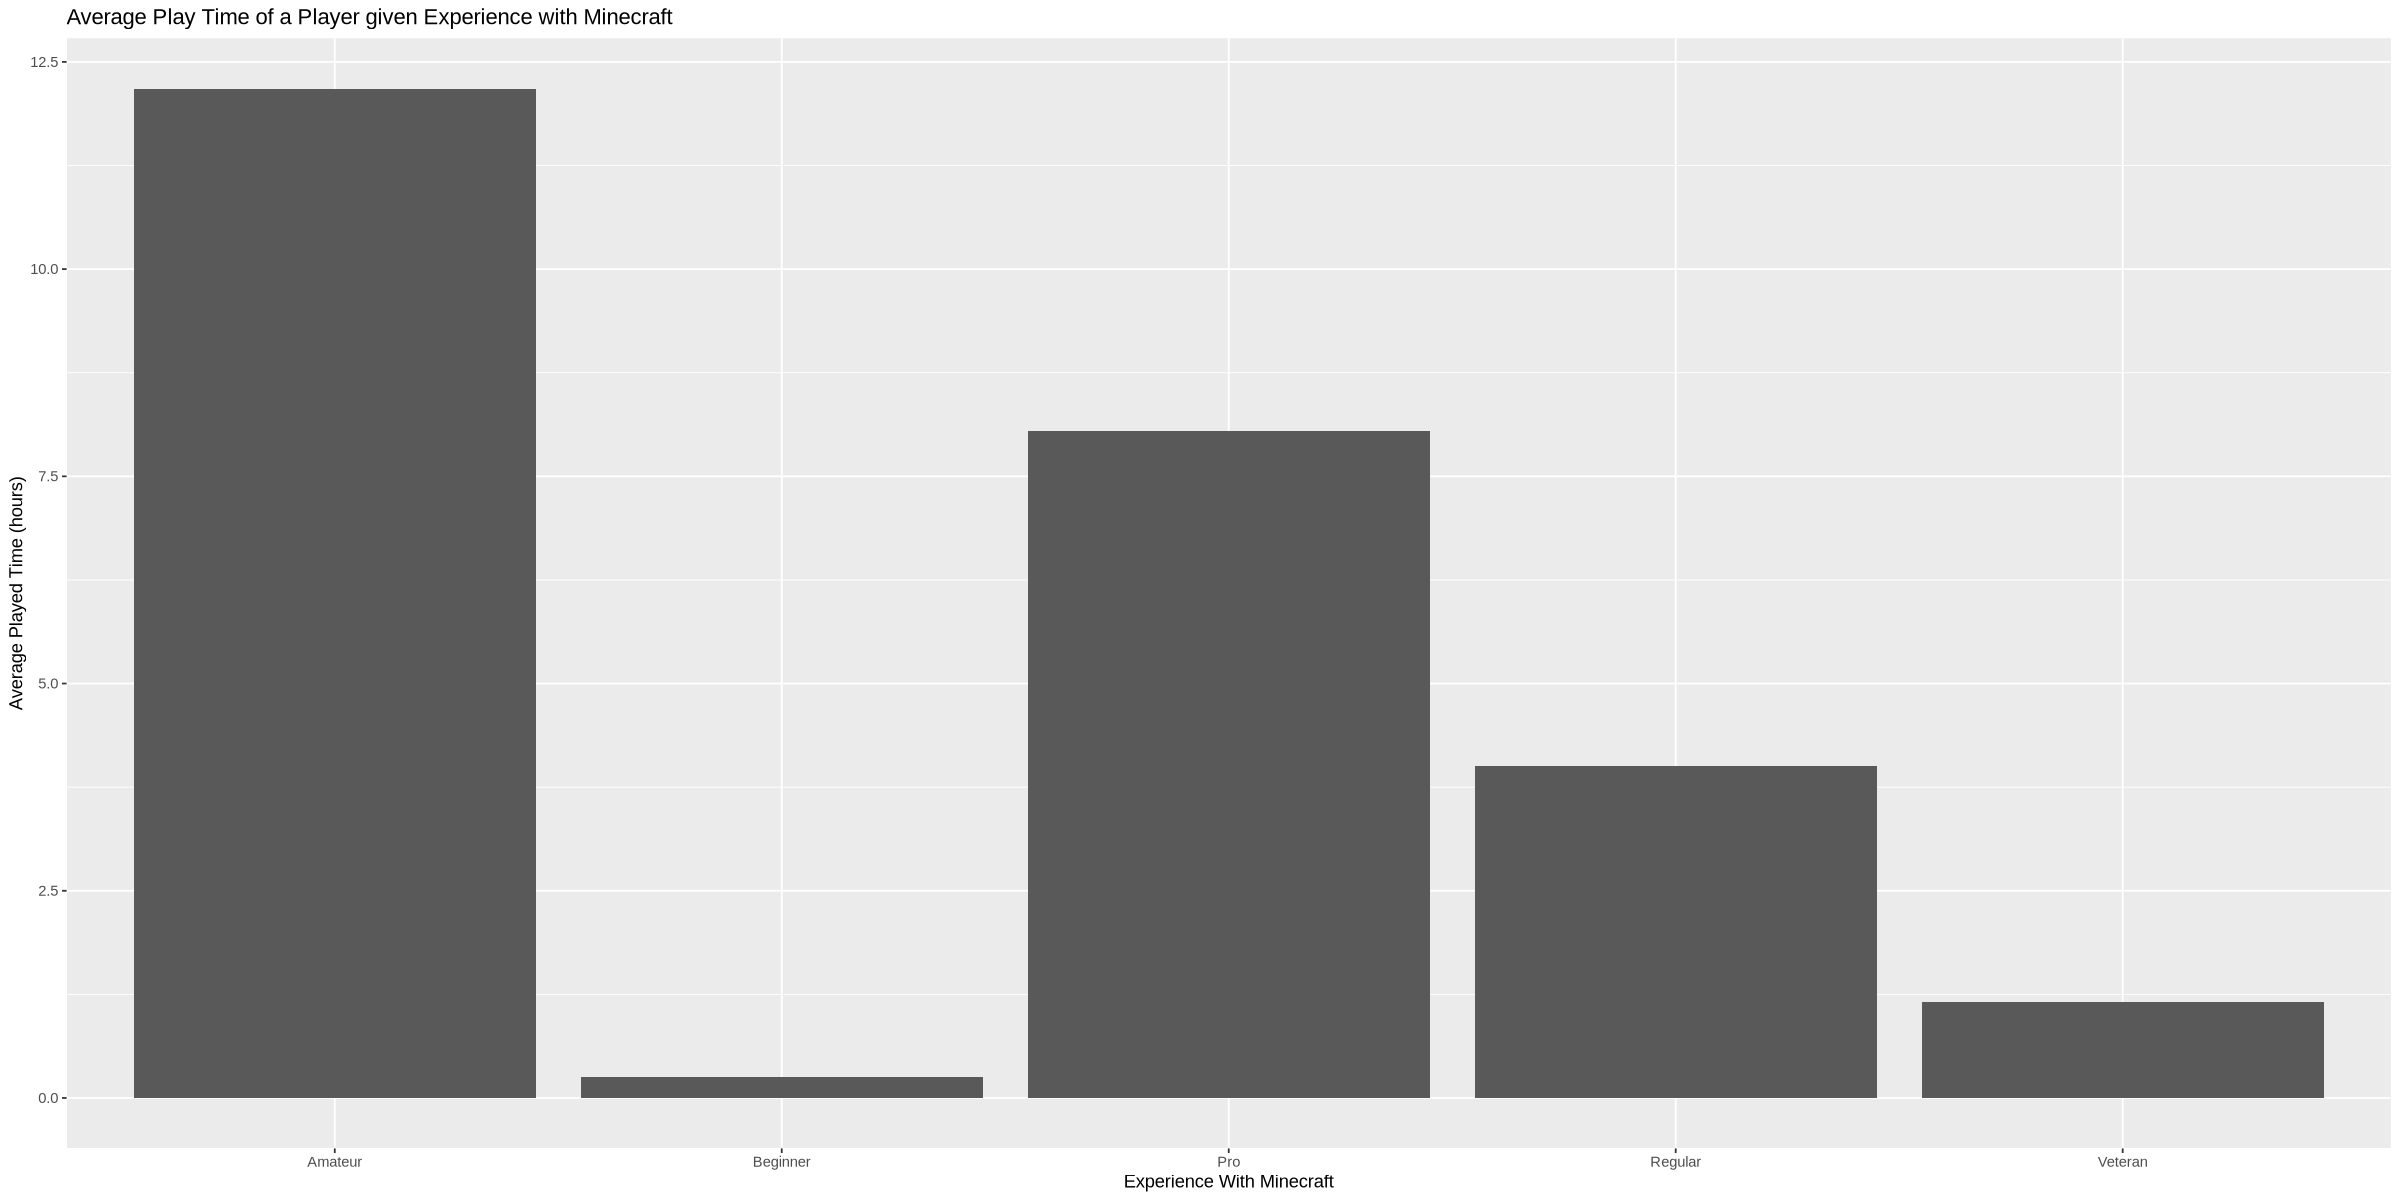

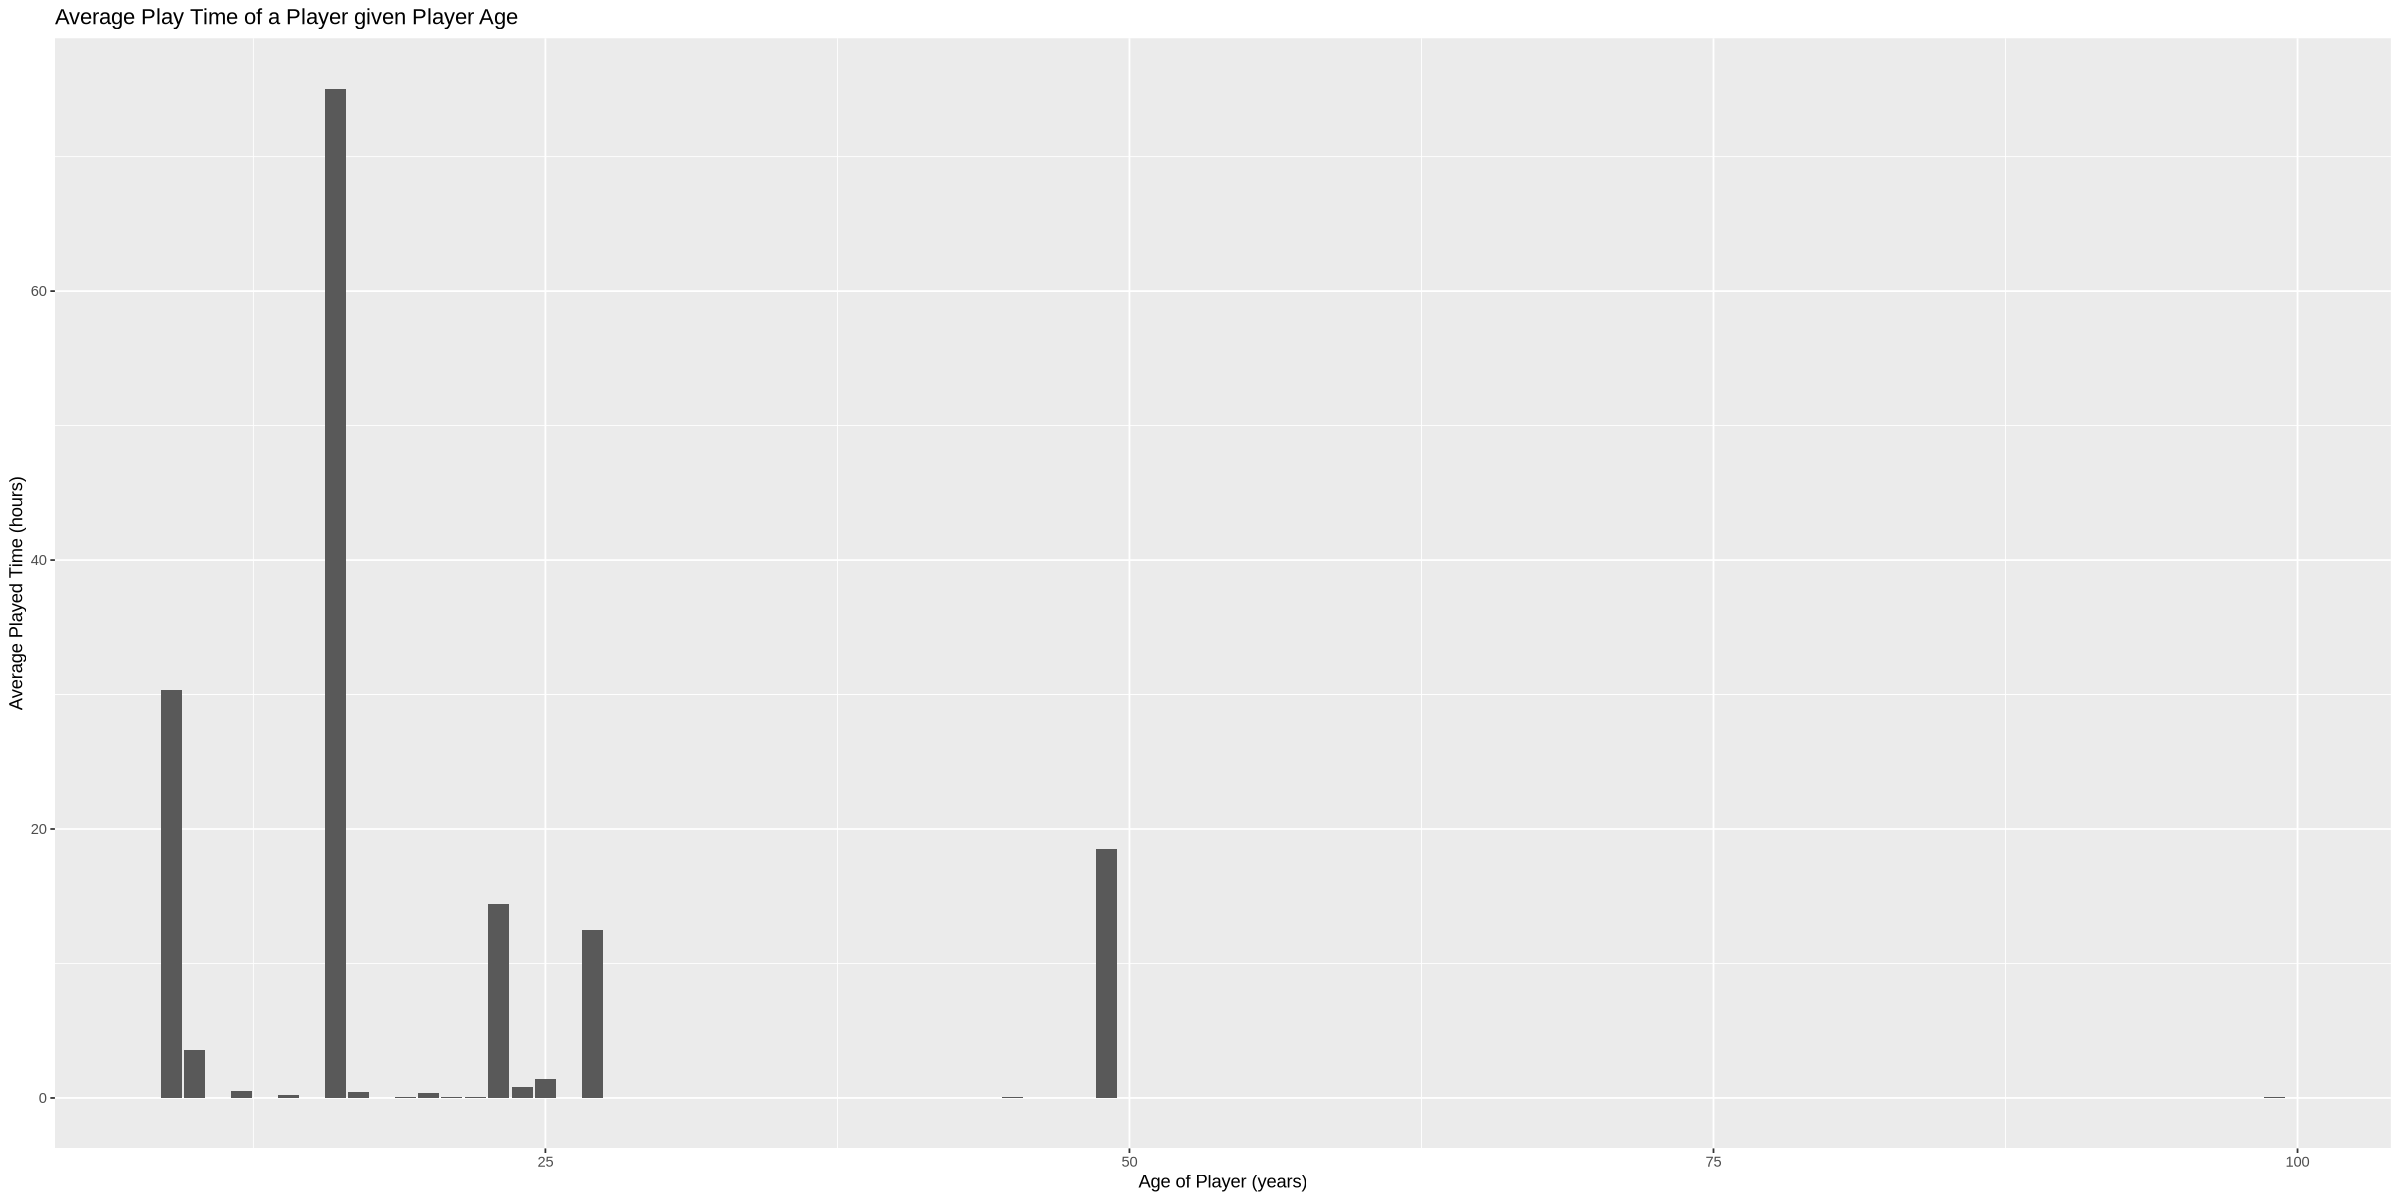

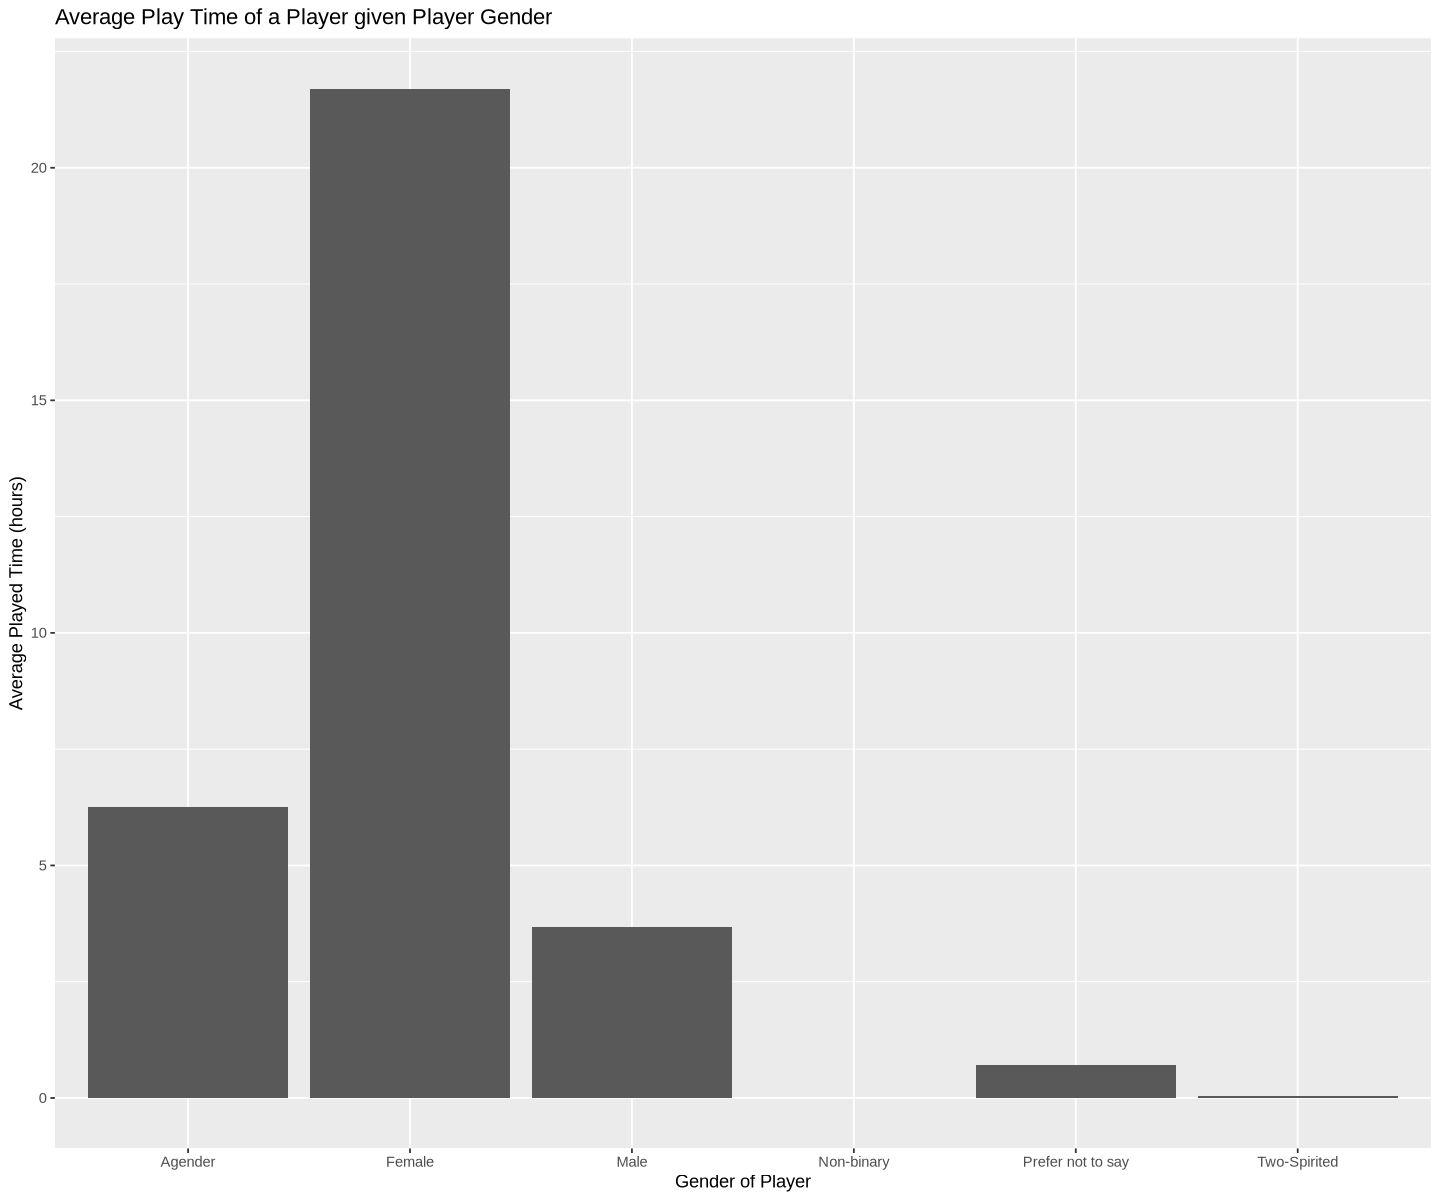

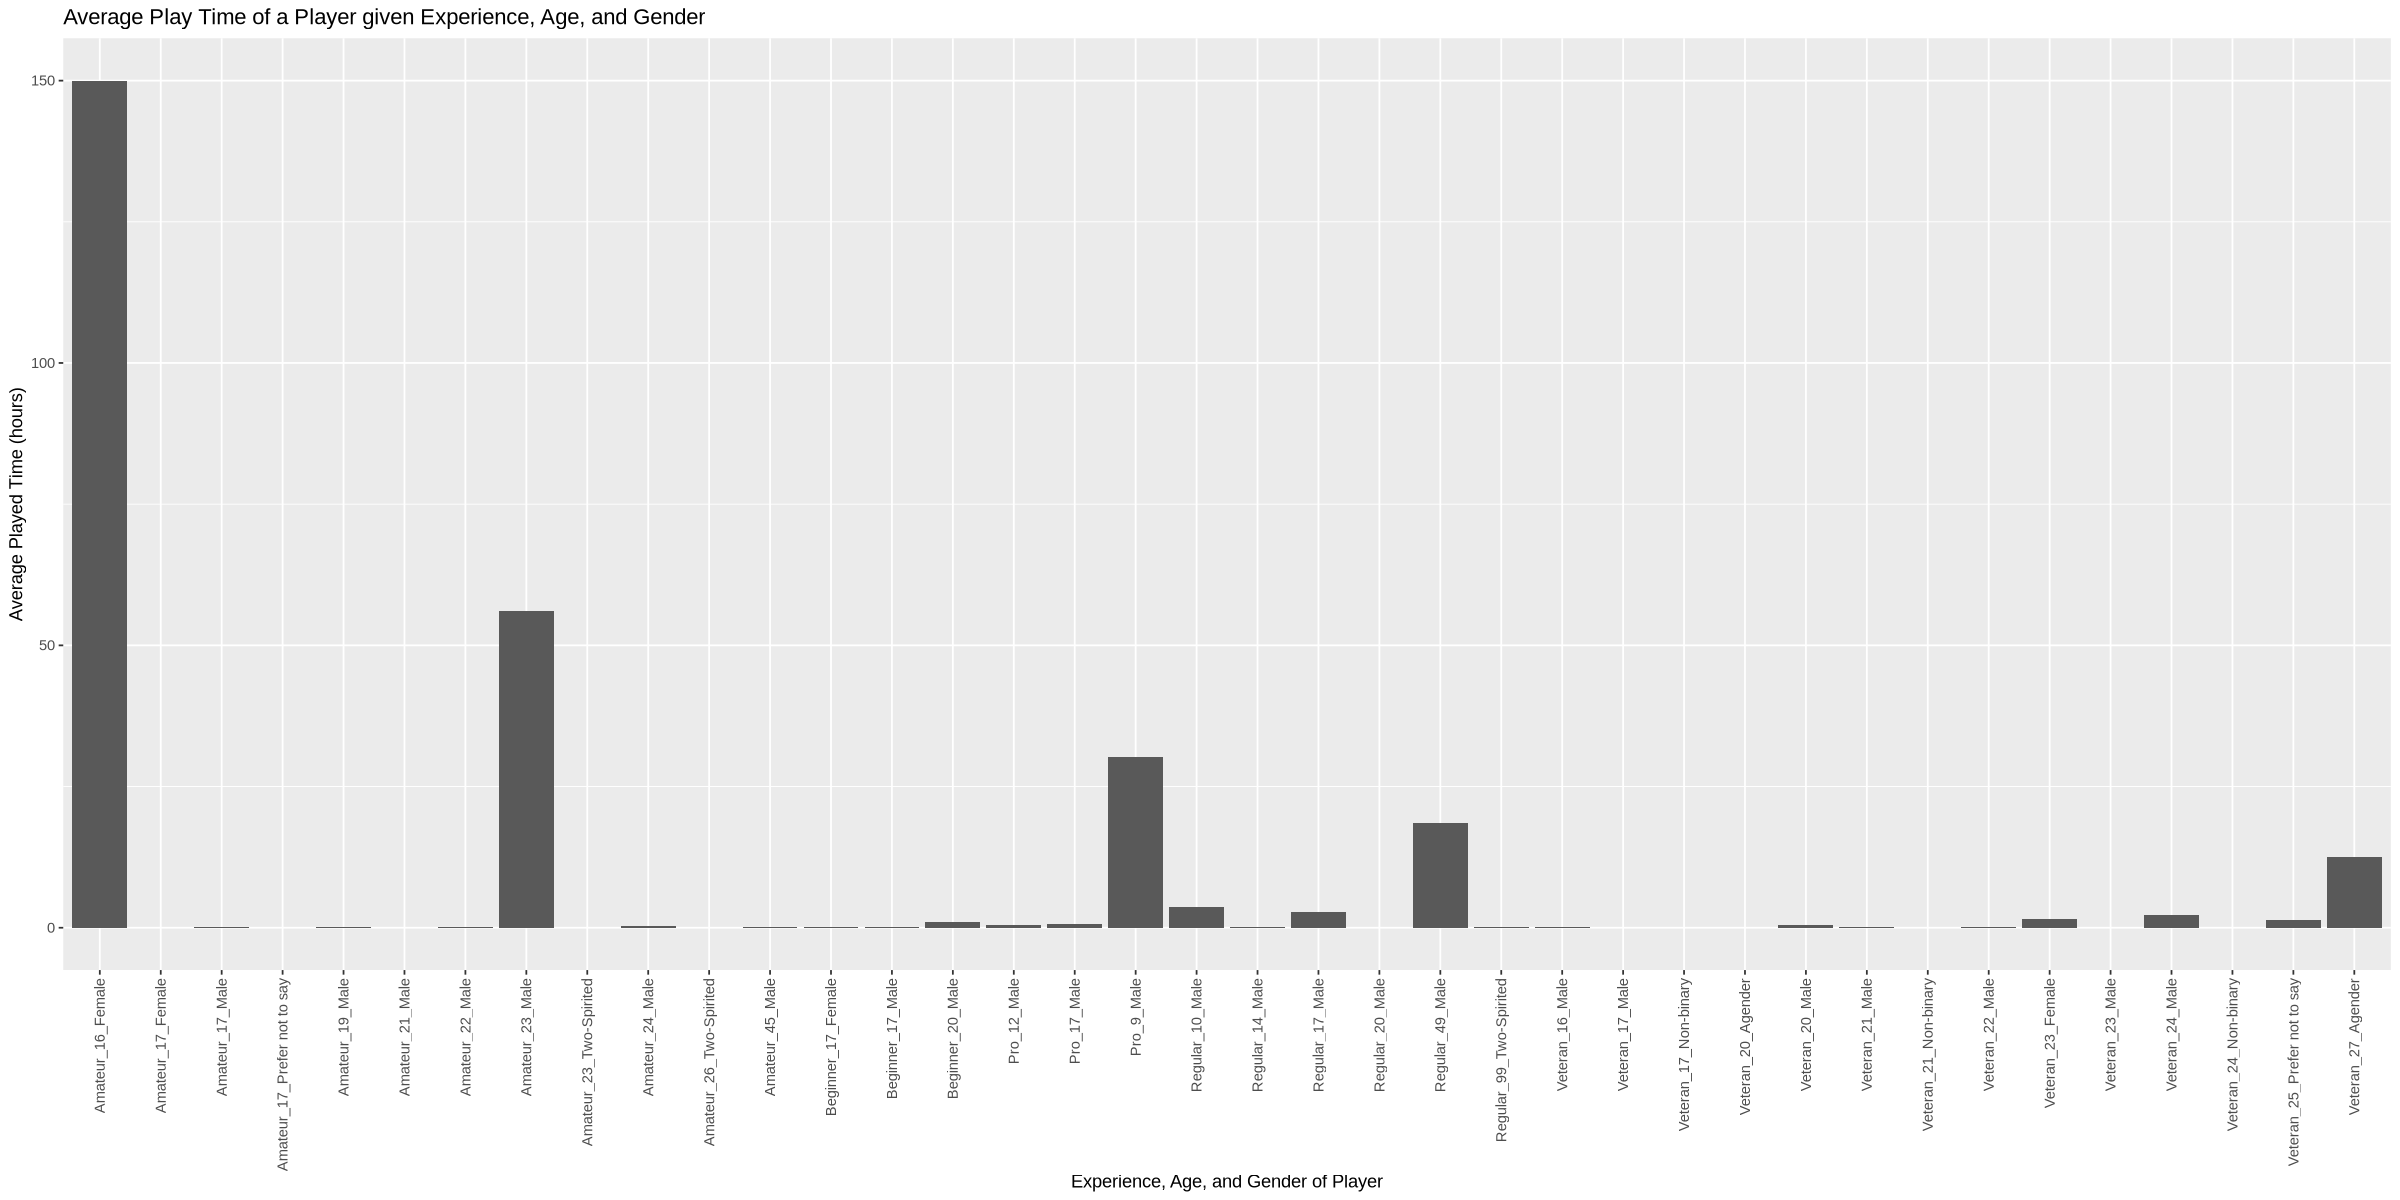

In [45]:
# Create knn regression spec using best k value
predict_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 74) |> 
      set_engine("kknn") |>
      set_mode("regression") 

# Create prediction fit
predict_fit <- workflow() |>
                add_recipe(predict_recipe) |>
                add_model(predict_spec) |>
                fit(data_training)

# Combine predicted values with the test data table
predict_table <- predict_fit |>
                    predict(data_testing) |>
                    bind_cols(data_testing)

# Create a table that outlines the averages of the differing groups for each individual quality (experience, age, gender)
experience_metrics <- predict_table |>
                    group_by(experience) |>
                    summarize(played_hours_avg = mean(played_hours))
experience_metrics
age_metrics <- predict_table |>
                    group_by(age) |>
                    summarize(played_hours_avg = mean(played_hours))
age_metrics
gender_metrics <- predict_table |>
                    group_by(gender) |>
                    summarize(played_hours_avg = mean(played_hours))
gender_metrics

# Create a table that outlines the averages of the differing groups pertaining to all qualities
all_metrics <- predict_table |>
                    group_by(experience, age, gender) |>
                    summarize(played_hours_avg = mean(played_hours), .groups = "keep") |>
                    ungroup() |>
                    mutate(combined = paste(experience, age, gender, sep = "_")) |>
                    select(-experience, -age, -gender)
all_metrics

                              
# Create plots for each of the averages collected for each grouping (individual and the combined)
experience_plot <- ggplot(experience_metrics, aes(x = experience, y = played_hours_avg)) +
    geom_bar(stat = "identity") +
    labs(x = "Experience With Minecraft", y = "Average Played Time (hours)", title = "Average Play Time of a Player given Experience with Minecraft")
experience_plot

options(repr.plot.width = 20, repr.plot.height = 10)
age_plot <- ggplot(age_metrics, aes(x = age, y = played_hours_avg)) +
    geom_bar(stat = "identity") +
    labs(x = "Age of Player (years)", y = "Average Played Time (hours)", title = "Average Play Time of a Player given Player Age")
age_plot

options(repr.plot.width = 12, repr.plot.height = 10)
gender_plot <- ggplot(gender_metrics, aes(x = gender, y = played_hours_avg)) +
    geom_bar(stat = "identity") +
    labs(x = "Gender of Player", y = "Average Played Time (hours)", title = "Average Play Time of a Player given Player Gender")
gender_plot

options(repr.plot.width = 20, repr.plot.height = 10)
combined_plot <- ggplot(all_metrics, aes(x = combined, y = played_hours_avg)) +
      geom_bar(stat = "identity") +
    labs(x = "Experience, Age, and Gender of Player", y = "Average Played Time (hours)", title = "Average Play Time of a Player given Experience, Age, and Gender") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
combined_plot

## **Discussion**

## **References**